In [1]:
import datetime
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.python.client import device_lib
import tensorflow_io as tfio

from performance_evaluation import plot_training_history, evaluate_model_performance

In [2]:
all_customer_engagement = pd.read_pickle(
    'data/AE_Clustering/all_customer_engagement.pkl'
).drop('custno', axis=1)

In [3]:
all_customer_engagement.head()

,E1:-1.0,E1:1.0,E1:10.0,E1:11.0,E1:2.0,E1:4.0,E1:5.0,E1:6.0,E1:7.0,E1:8.0,...,P2:90.0,P2:91.0,P2:92.0,P2:93.0,P2:94.0,P2:95.0,P2:96.0,P2:97.0,P2:98.0,P2:99.0
0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,49.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,65.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,20.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Encode Customer Engagement

In [4]:
Xs = all_customer_engagement.values

In [5]:
encoder = keras.models.load_model('data/AE_Clustering/encoder.h5')

In [6]:
cust_encodings = encoder.predict(Xs)

#### Validate that predictions range betweeen -1 and 1 for all variables. 

In [7]:
pd.DataFrame(cust_encodings).describe()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
count,63901.000000,63901.000000,63901.000000,63901.000000,63901.000000,63901.000000,63901.000000,63901.000000,63901.000000,63901.000000,...,63901.000000,63901.000000,63901.000000,63901.000000,63901.000000,63901.000000,63901.000000,63901.000000,63901.000000,63901.000000
mean,0.138159,0.064628,-0.077943,0.255132,0.196226,0.024565,-0.226669,0.065302,-0.137121,-0.176708,...,0.100814,0.194526,0.163162,-0.196011,0.095884,-0.230394,0.350982,0.172994,0.117882,0.036691
std,0.241857,0.215367,0.216416,0.209165,0.221375,0.317046,0.276555,0.325870,0.281570,0.223803,...,0.218634,0.278527,0.209549,0.185014,0.361866,0.325953,0.254175,0.267631,0.193609,0.293436
min,-0.999999,-0.999872,-0.956004,-1.000000,-0.999997,-1.000000,-1.000000,-1.000000,-1.000000,-0.931186,...,-1.000000,-0.999723,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.905770,-1.000000,-1.000000
25%,0.045160,-0.034166,-0.216730,0.216925,0.080629,-0.157222,-0.326626,-0.183497,-0.271253,-0.313963,...,-0.045134,-0.002395,0.100419,-0.249922,-0.172591,-0.448944,0.221628,-0.044069,0.031957,-0.110863
50%,0.144643,0.074095,-0.126938,0.303446,0.223042,-0.057559,-0.213260,0.058531,-0.145694,-0.230593,...,0.130019,0.195090,0.193820,-0.161751,0.087708,-0.267251,0.385133,0.161995,0.117018,0.026096
75%,0.247992,0.164870,-0.002978,0.365640,0.325390,0.141791,-0.127317,0.346627,0.018450,-0.112469,...,0.272230,0.356115,0.285589,-0.088045,0.381608,-0.021683,0.497102,0.338882,0.202991,0.149351
max,1.000000,1.000000,1.000000,0.940320,0.999999,1.000000,1.000000,1.000000,0.999996,1.000000,...,0.712651,1.000000,0.933814,0.961642,1.000000,1.000000,1.000000,1.000000,1.000000,0.999999


# Determine # of Clusters

In [8]:
from sklearn.cluster import KMeans

In [9]:
# Cacluate WSS for different cluster counts
Ks = np.arange(1, 20)
km = [KMeans(n_clusters=i) for i in Ks]
WSS = [km[i].fit(cust_encodings).score(cust_encodings)*-1 for i in range(len(km))]

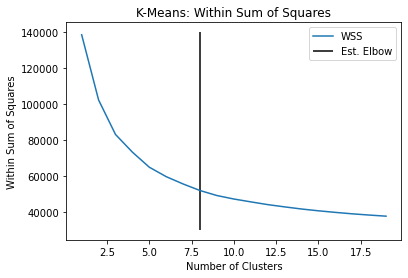

In [10]:
plt.plot(Ks, WSS, label='WSS')
plt.title('K-Means: Within Sum of Squares')
plt.xlabel('Number of Clusters')
plt.ylabel('Within Sum of Squares')
plt.vlines(8, 30000, 140000, label='Est. Elbow')
plt.legend()
plt.show()

# Train Clustering Algorithm

In [11]:
Final_KM = KMeans(8)
Final_KM.fit(cust_encodings)

KMeans()

In [12]:
cluster_assignment = Final_KM.predict(cust_encodings)

# Visualize with T-SNE

In [13]:
from sklearn.manifold import TSNE

In [14]:
cust_tsne = TSNE(2, n_jobs=-1)

In [15]:
cust_tsne.fit(Xs)

TSNE(n_jobs=-1)

In [16]:
tsne_df = pd.DataFrame(cust_tsne.embedding_, columns=['embedding_1', 'embedding_2'])

In [17]:
tsne_df['clust_assign'] = all_customer_engagement['clust_assign']

KeyError: 'clust_assign'

In [ ]:
cluster_nums = list(set(tsne_df['clust_assign']))

In [ ]:
color = ['blue', 'black', 'green', 'orange', 'pink','red', 'purple', 'grey']

In [ ]:
plt.title('Scatter Plot of Clustering Tightness')
for i in range(len(cluster_nums)):
    scatter_points = tsne_df[tsne_df['clust_assign']==cluster_nums[i]]
    plt.scatter(
        scatter_points['embedding_1'], 
        scatter_points['embedding_2'], 
        c=color[i],
        label=cluster_nums[i]
    )
plt.show()

# Calculate Average Stats for Each Cluster

In [ ]:
all_customer_engagement['clust_assign'] = cluster_assignment

In [ ]:
cluster_averages = all_customer_engagement.groupby('clust_assign', as_index=False).mean()

In [ ]:
pd.set_option('display.max_rows', 1000)

In [ ]:
import seaborn as sns

cm = sns.light_palette("green", as_cmap=True)

cluster_averages_shaded = cluster_averages.T.style.background_gradient(low=0, high=0, cmap=cm, axis=1)

#### Note: I have no idea what each of the events and products are. This makes it hard to assign names to each of the clusters and manually inspect if these are useful clusters for marketing purposes. However, listed below you can see how each of the different clusters differ from one another by looking at the shading for each row.

In [ ]:
cluster_averages_shaded